In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.v2.functional as F_v2
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from Deep_Learning.Representation_Learning.AugPC.train import train
from Deep_Learning.Representation_Learning.AugPC.model import Model

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)


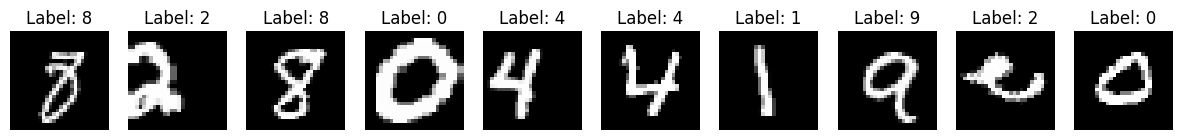

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [4]:
# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    angle = torch.rand(1).item() * 360 - 180 if torch.rand(1).item() > 0.75 else 0
    translate_x = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    translate_y = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    scale = torch.rand(1).item() * 0.5 + 0.75 if torch.rand(1).item() > 0.75 else 1.0
    shear = torch.rand(1).item() * 50 - 25 if torch.rand(1).item() > 0.75 else 0
    img = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [7]:
# log_dir = None
model_name = 'AugPC-resnet18-big_project'
log_dir = f'Deep_Learning/Representation_Learning/logs/{model_name}/'
save_dir = f'Deep_Learning/Representation_Learning/AugPC/models/{model_name}.pth'
# log_dir = None
# save_dir = None
writer = None
if log_dir is not None:
    writer = SummaryWriter(log_dir)
model = Model(in_features=1, num_actions=5).to(device)

In [8]:
# TOOK 26m 18.8s

In [9]:
to_train = True
if save_dir is not None:
    try:
        model.load_state_dict(torch.load(save_dir))
        to_train = False
    except FileNotFoundError:
        pass
        print('Model not found, training new model')
if to_train:
    train(
        model,
        train_set,
        val_set,
        num_epochs=500,
        batch_size=128,
        lr=0.001,
        wd=1.5e-6,
        writer=writer,
        save_dir=save_dir,
        save_every=5,
        aug_scaler='none'
    )

Model not found, training new model


In [13]:
print("Loading Best Model")
if save_dir is not None:
    try:
        model.load_state_dict(torch.load(save_dir))
    except FileNotFoundError:
        print('Model not found')

Loading Best Model


In [29]:
# collect 100 of each target index from train_set.targets

In [32]:
classifier = nn.Linear(1000, 10, bias=False).to(device)

num_epochs = 100
batch_size = 100
lr = 0.01
optimiser = torch.optim.AdamW(classifier.parameters(), lr=lr)

indices = []
for i in range(10):
    idx = train_set.targets == i
    indices.append(torch.where(idx)[0][:100])
indices = torch.cat(indices)
train1k = PreloadedDataset.from_dataset(train_set, train_transform, device)
train1k.images = train1k.images[indices]
train1k.transformed_images = train1k.transformed_images[indices]
train1k.targets = train1k.targets[indices]

train_loader = DataLoader(train1k, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
scaler = torch.cuda.amp.GradScaler()

last_train_loss = torch.tensor(-1, device=device)
last_train_acc = torch.tensor(-1, device=device)
last_val_loss = torch.tensor(-1, device=device)
last_val_acc = torch.tensor(-1, device=device)

postfix = {}
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    loop.set_description(f'Epoch [{epoch}/{num_epochs}]')
    if epoch > 0:
        loop.set_postfix(postfix)
    epoch_train_loss = torch.zeros(len(train_loader), device=device)
    epoch_train_acc = torch.zeros(len(train_loader), device=device)
    for i, (x, y) in loop:
        with torch.cuda.amp.autocast():
            with torch.no_grad():
                z = model(x)
            y_pred = classifier(z)
            loss = F.cross_entropy(y_pred, y)
        optimiser.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimiser)
        scaler.update()

        epoch_train_loss[i] = loss.detach()
        epoch_train_acc[i] = (y_pred.argmax(dim=1) == y).float().mean().detach()

    last_train_loss = epoch_train_loss.mean()
    last_train_acc = epoch_train_acc.mean()
    
    with torch.no_grad():
        epoch_val_loss = torch.zeros(len(val_loader), device=device)
        epoch_val_acc = torch.zeros(len(val_loader), device=device)
        for i, (x, y) in enumerate(val_loader):
            with torch.cuda.amp.autocast():
                z = model(x)
                y_pred = classifier(z)
                loss = F.cross_entropy(y_pred, y)
            epoch_val_loss[i] += loss.detach()
            epoch_val_acc[i] += (y_pred.argmax(dim=1) == y).float().mean().detach()

        last_val_loss = epoch_val_loss.mean().detach() 
        last_val_acc = epoch_val_acc.mean().detach()
    
    if writer is not None:
        writer.add_scalar('Classifier/train_loss', last_train_loss.item(), epoch)
        writer.add_scalar('Classifier/train_acc', last_train_acc.item(), epoch)
        writer.add_scalar('Classifier/val_loss', last_val_loss.item(), epoch)
        writer.add_scalar('Classifier/val_acc', last_val_acc.item(), epoch)
    
    postfix = {
        'train_loss': last_train_loss.item(),
        'train_acc': last_train_acc.item(),
        'val_loss': last_val_loss.item(),
        'val_acc': last_val_acc.item(),
    }
    loop.set_postfix(postfix)
    loop.close()

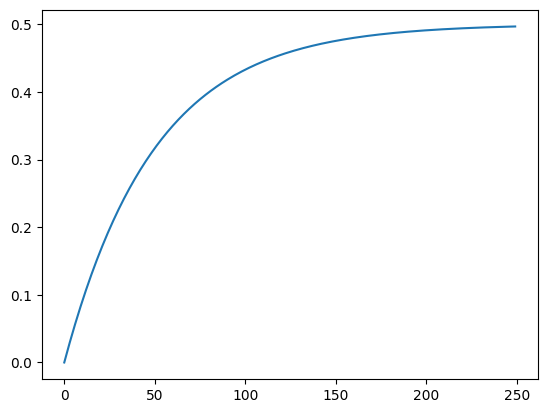

In [11]:
aug_ps = (1.0 - torch.exp(torch.linspace(0, -5, 250))) * 0.5
plt.plot(aug_ps, label='Augmentation Probability')

In [12]:
img = train_set[4][0].unsqueeze(0)
model.eval()

def compare(model, img, angle, translate_x, translate_y, scale, shear):
    img_aug = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    action = torch.tensor([angle/180, translate_x/8, translate_y/8, (scale-1.0)/0.25, shear/25], dtype=torch.float32, device=img.device).unsqueeze(0).repeat(img.shape[0], 1)
    img_pred = model.predict(img, action)
    loss = F.mse_loss(img_aug, img_pred)
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img.squeeze().cpu(), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(img_aug.squeeze().cpu(), cmap='gray')
    axes[1].set_title('Augmented')
    axes[1].axis('off')
    axes[2].imshow(img_pred.squeeze().cpu().detach(), cmap='gray')
    axes[2].set_title('Predicted')
    axes[2].axis('off')
    plt.show()
    return loss.item()

interact(compare, model=fixed(model), img=fixed(img), angle=(-180, 180), translate_x=(-8, 8), translate_y=(-8, 8), scale=(0.75, 1.25), shear=(-25, 25))

interactive(children=(IntSlider(value=0, description='angle', max=180, min=-180), IntSlider(value=0, descripti…

<function __main__.compare(model, img, angle, translate_x, translate_y, scale, shear)>